# # TP3 – Question 2 : Segmentation + Tracking CNN sur DIC-C2DH-HeLa
# Dataset situé dans : /kaggle/input/hela-cell-tp3/DIC-C2DH-HeLa/DIC-C2DH-HeLa/
## Objectif
Segmenter automatiquement des cellules HeLa dans une séquence DIC
à l’aide de Cellpose, puis reconstruire leurs trajectoires avec TrackPy.


In [43]:
pip install cellpose tifffile numpy matplotlib scikit-image trackpy

Note: you may need to restart the kernel to use updated packages.


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from cellpose import models
import trackpy as tp
from skimage.measure import regionprops_table

import cellpose
import os

# 1. Chargement de la séquence temporelle 01

In [45]:
folder = "/kaggle/input/hela-cell-tp3/DIC-C2DH-HeLa/DIC-C2DH-HeLa/01/"

image_paths = sorted(glob.glob(folder + "*.tif"))
print("Nombre de frames :", len(image_paths))

stack = np.array([tiff.imread(p).astype(np.float32) for p in image_paths])
T, H, W = stack.shape
print("Stack shape :", stack.shape)

# Normalisation 0–1
stack = (stack - stack.min()) / (stack.max() - stack.min())

Nombre de frames : 84
Stack shape : (84, 512, 512)


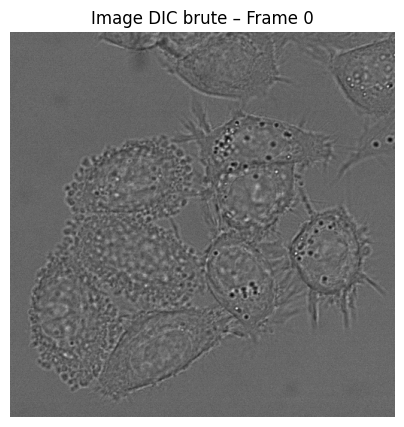

In [46]:
os.makedirs("figures", exist_ok=True)

plt.figure(figsize=(5,5))
plt.imshow(stack[0], cmap="gray")
plt.title("Image DIC brute – Frame 0")
plt.axis("off")

plt.savefig("figures/dic_frame0.png", dpi=300, bbox_inches="tight")
plt.show()

## 2. Segmentation CNN (Cellpose)

In [47]:
model = models.CellposeModel(gpu=True)

masks_list = []

T = stack.shape[0]

for t in range(T):
    img = stack[t]
    
    # si image multicanal
    if img.ndim == 3:
        img = img[..., 0]

    out = model.eval(
        img,
        diameter=30,
        flow_threshold=0.4,
        cellprob_threshold=0.0
    )

    # compatibilité CellPose v3 / v4
    if len(out) == 4:
        masks, flows, styles, diams = out
    else:
        masks, flows, styles = out

    print(f"Frame {t}: {int(masks.max())} cellules détectées")
    masks_list.append(masks.astype(np.uint16))

masks_stack = np.stack(masks_list, axis=0)
print("Segmentation Cellpose terminée")

Frame 0: 12 cellules détectées
Frame 1: 8 cellules détectées
Frame 2: 10 cellules détectées
Frame 3: 9 cellules détectées
Frame 4: 12 cellules détectées
Frame 5: 18 cellules détectées
Frame 6: 12 cellules détectées
Frame 7: 12 cellules détectées
Frame 8: 12 cellules détectées
Frame 9: 13 cellules détectées
Frame 10: 12 cellules détectées
Frame 11: 14 cellules détectées
Frame 12: 12 cellules détectées
Frame 13: 13 cellules détectées
Frame 14: 13 cellules détectées
Frame 15: 13 cellules détectées
Frame 16: 13 cellules détectées
Frame 17: 12 cellules détectées
Frame 18: 14 cellules détectées
Frame 19: 14 cellules détectées
Frame 20: 12 cellules détectées
Frame 21: 14 cellules détectées
Frame 22: 14 cellules détectées
Frame 23: 14 cellules détectées
Frame 24: 14 cellules détectées
Frame 25: 14 cellules détectées
Frame 26: 13 cellules détectées
Frame 27: 14 cellules détectées
Frame 28: 15 cellules détectées
Frame 29: 14 cellules détectées
Frame 30: 16 cellules détectées
Frame 31: 16 cellule

In [48]:
model = models.CellposeModel(
    model_type='cyto2',
    gpu=True
)

masks, flows, styles = model.eval(
    img,
    channels=[0, 0],
    diameter=30,
    flow_threshold=0.4
)

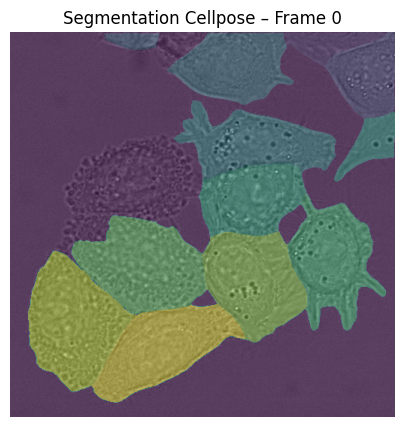

In [49]:
plt.figure(figsize=(5,5))
plt.imshow(stack[0], cmap="gray")
plt.imshow(masks_stack[0], alpha=0.4)
plt.title("Segmentation Cellpose – Frame 0")
plt.axis("off")

plt.savefig("figures/cellpose_segmentation_frame0.png", dpi=300, bbox_inches="tight")
plt.show()

## 3. Extraction des centroïdes des cellules

In [50]:
rows = []

for t in range(T):
    props = regionprops_table(
        masks_stack[t],
        properties=["label", "centroid"]
    )
    df = pd.DataFrame(props)
    df["frame"] = t
    rows.append(df)

df_centroids = pd.concat(rows, ignore_index=True)
df_centroids.rename(columns={
    "centroid-0": "y",
    "centroid-1": "x"
}, inplace=True)

df_centroids.head()

,label,y,x,frame
0,1,14.606752,423.154736,0
1,2,58.750342,474.375376,0
2,3,10.763037,164.292178,0
3,4,44.903669,297.817459,0
4,5,146.564860,323.997446,0


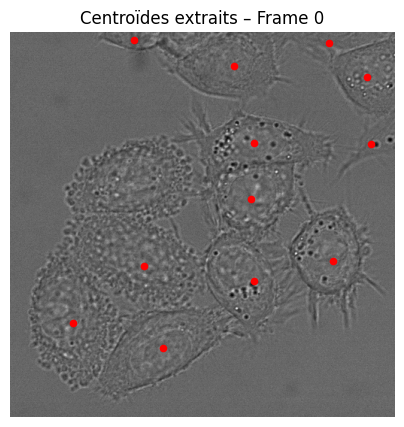

In [51]:
df0 = df_centroids[df_centroids.frame == 0]

plt.figure(figsize=(5,5))
plt.imshow(stack[0], cmap="gray")
plt.scatter(df0["x"], df0["y"], c="red", s=20)
plt.title("Centroïdes extraits – Frame 0")
plt.axis("off")

plt.savefig("figures/centroids_frame0.png", dpi=300, bbox_inches="tight")
plt.show()

# 4. Tracking avec TrackPy (Nearest Neighbour)

In [52]:
tracks = tp.link(
    df_centroids,
    search_range=25,
    memory=3
)

tracks.head()

Frame 83: 20 trajectories present.


,label,y,x,frame,particle
0,1,14.606752,423.154736,0,0
1,2,58.750342,474.375376,0,1
2,3,10.763037,164.292178,0,2
3,4,44.903669,297.817459,0,3
8,9,310.177857,177.172283,0,4



## 5. Visualisation des trajectoires superposées à la première frame

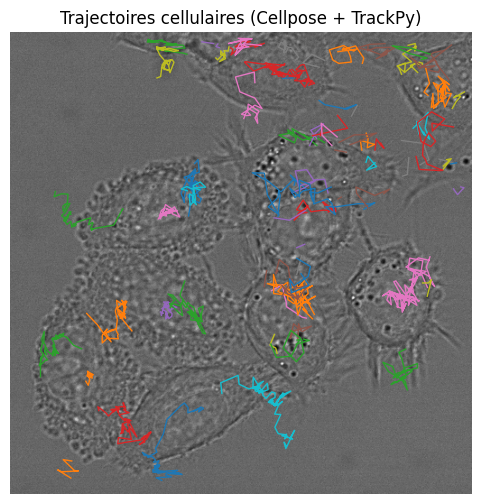

In [53]:
plt.figure(figsize=(6,6))
plt.imshow(stack[0], cmap="gray")

for pid, tr in tracks.groupby("particle"):
    plt.plot(tr["x"], tr["y"], "-", linewidth=1)

plt.title("Trajectoires cellulaires (Cellpose + TrackPy)")
plt.axis("off")

plt.savefig("figures/HeLa_trajectories.png", dpi=300, bbox_inches="tight")
plt.show()


## 6. Sauvegarde des trajectoires


In [54]:
tracks.to_csv("HeLa_trajectories.csv", index=False)
print("Trajectoires enregistrées dans : HeLa_trajectories.csv")

Trajectoires enregistrées dans : HeLa_trajectories.csv


## Discussion

Les trajectoires reconstruites montrent des déplacements lents et
confinés, caractéristiques de cellules HeLa adhérentes.  
L’approche Cellpose permet une segmentation entièrement automatique,
tandis que TrackPy reconstruit efficacement les trajectoires malgré
des disparitions temporaires. Les performances restent dépendantes
des paramètres (diameter, seuils) et de la qualité du contraste.
